### Background Info
I initially created my own CNN from scratch and trained it for 100 epochs. In the end, the model only achieved 69% and 56% accuracy on the training and test sets respectively. I figured a model that was slightly better than a coin toss wouldn't be worth sharing, so I needed to figure something else out. One of the obvious problems is that with only 537 images, my dataset is extremely small. For comparison, CIFAR-10 contains 60,000 images with 6,000 images for each of the 10 classes. So I needed a way to get around the fact that my dataset was so small, which brought me to the idea of using a pretrained model as the lower layers of my model. I decided to use the Xception pretrained model offered by Keras, and I was impressed with the results.

--------

### Get the images
After running the web scraping code from the other notebook, you should have 537 images stored in a directory called "us_congress_images".

In [33]:
import os

images_path = os.getcwd() + '/us_congress_images'
image_files = [name for name in os.listdir(images_path) if '.ipynb_checkpoints' not in name]

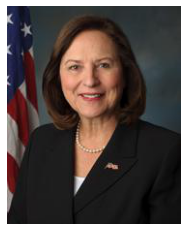

In [34]:
from PIL import Image
import matplotlib.pyplot as plt

# Display an image to test
im = Image.open(images_path + '/' + image_files[0])
plt.imshow(im)
plt.axis("off")
plt.show()

#### *Resize all the images so they have the same dimensions*

In [35]:
x_dim = 256
y_dim = 256

resized_images = []
for file in image_files:
    im = Image.open(images_path + '/' + file)
    img = im.resize((x_dim, y_dim))
    resized_images.append(img)

In [37]:
len(resized_images)

537

### Create the dataset

Use the images as inputs and the party affiliations, which were stored as part of the file names, as integer labels.

In [38]:
import numpy as np

# Make the pixels scaled floats between 0-255
X_data = np.array([
    np.array(file) for file in resized_images
]) / 255.

# Democrats will be 0; Republicans will be 1
y_data = np.array([
    0 if "democrat" in file else 1 for file in image_files
]).astype('uint8')

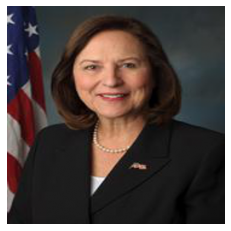

Party label:  1


In [39]:
# Display an image to test
plt.imshow(X_data[0])
plt.axis("off")
plt.show()
print('Party label: ', y_data[0])

### Split data into train, validation, and test sets.

In [40]:
# First check the class balance between Democrats and Republicans

print("Proportion of Republicans in Congress: ", y_data.sum() / len(y_data))

Proportion of Republicans in Congress:  0.48044692737430167


There are slightly more Democrats than Republicans, but the dataset has a pretty even class balance. Nevertheless, I will still pass y_data to the stratify variable to make sure this balance is roughly maintained after the splits.

In [41]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(X_data, y_data, test_size=0.1, shuffle=True, 
                                                              stratify=y_data, random_state=42)

In [42]:
# Split train_full into training and validation sets

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.15, shuffle=True, 
                                                      stratify=y_train_full, random_state=42)

In [43]:
# Check the shape of the datasets
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(410, 256, 256, 3)
(73, 256, 256, 3)
(54, 256, 256, 3)
(410,)
(73,)
(54,)


In [44]:
# Check that the class balance is roughly maintained across the sets
print(y_train.sum() / len(y_train))
print(y_valid.sum() / len(y_valid))
print(y_test.sum() / len(y_test))

0.48048780487804876
0.4794520547945205
0.48148148148148145


### Preprocess the images
Before using a pretrained model, you must pass the data through the model's preprocess_input function.
I will be using the Xception pretrained model supported by Keras. 

In [1]:
import tensorflow as tf
from tensorflow import keras

In [28]:
# Pass each image into Xception's preprocessing function
X_train = np.array([keras.applications.xception.preprocess_input(image) for image in X_train])
X_valid = np.array([keras.applications.xception.preprocess_input(image) for image in X_valid])
X_test = np.array([keras.applications.xception.preprocess_input(image) for image in X_test])

### Build and train the model

In [29]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

#### *Use the Keras functional API to set up the model.*

In [30]:
# Set include_top=False because I will add my own fully connected layer at the top of the network in order to tailor
# the pretrained model to my specific binary classification task
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False, 
                                                  input_shape=(x_dim, y_dim, 3)) 
    
# Pooling layer
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)

# My own fully connected layer with 1 neuron and a sigmoid activation for binary classification
output = keras.layers.Dense(1, activation="sigmoid")(avg)

model = keras.models.Model(inputs=base_model.input, outputs=output)

In [31]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

For the first few epochs of training, I will freeze the weights of the base/pretrained model so only the Dense layer that I added at the top of the network will learn new weights. This is to prevent the pretrained layers from having their fune-tuned weights drastically changed at the beginning of training, when training can be very unstable. Later, I will unfreeze the base model's weights so I can train the entire network.

In [17]:
# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

In [18]:
# Finally, compile the model and start training the top layer

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

#### *Train the model for a few epochs to prime the custom top layer*

In [19]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
13/13 [==============================] - 62s 5s/step - loss: 0.7192 - accuracy: 0.5000 - val_loss: 0.8637 - val_accuracy: 0.5205
Epoch 2/10
13/13 [==============================] - 60s 5s/step - loss: 0.7722 - accuracy: 0.5220 - val_loss: 1.2215 - val_accuracy: 0.5205
Epoch 3/10
13/13 [==============================] - 58s 4s/step - loss: 1.0292 - accuracy: 0.5146 - val_loss: 0.7038 - val_accuracy: 0.5205
Epoch 4/10
13/13 [==============================] - 58s 4s/step - loss: 0.9767 - accuracy: 0.5341 - val_loss: 0.6810 - val_accuracy: 0.5205
Epoch 5/10
13/13 [==============================] - 58s 4s/step - loss: 0.8287 - accuracy: 0.4683 - val_loss: 0.9572 - val_accuracy: 0.5205
Epoch 6/10
13/13 [==============================] - 59s 5s/step - loss: 0.7961 - accuracy: 0.5439 - val_loss: 1.5123 - val_accuracy: 0.4795
Epoch 7/10
13/13 [==============================] - 57s 4s/step - loss: 1.0759 - accuracy: 0.5146 - val_loss: 0.7037 - val_accuracy: 0.4795
Epoch 8/10
13/13 [==

#### Now that you've trained the top layer a bit, you can unfreeze the base_model's pretrained layers and train the entire model

In [20]:
# Unfreeze the base model's layers
for layer in base_model.layers:
    layer.trainable = True

In [21]:
# Because you unfroze layers, you need to compile the model again. Use a smaller learning rate this time.
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True, decay=0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

#### *Train the model for 100 epochs* (This may take a while on a regular CPU, so consider running this overnight)

In [71]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/20
13/13 [==============================] - 293s 23s/step - loss: 3.0904e-04 - accuracy: 1.0000 - val_loss: 1.1951 - val_accuracy: 0.6712
Epoch 2/20
13/13 [==============================] - 302s 23s/step - loss: 5.0592e-04 - accuracy: 1.0000 - val_loss: 1.1913 - val_accuracy: 0.6712
Epoch 3/20
13/13 [==============================] - 294s 23s/step - loss: 6.5273e-04 - accuracy: 1.0000 - val_loss: 1.1959 - val_accuracy: 0.6849
Epoch 4/20
13/13 [==============================] - 304s 23s/step - loss: 4.0354e-04 - accuracy: 1.0000 - val_loss: 1.1872 - val_accuracy: 0.6986
Epoch 5/20
13/13 [==============================] - 305s 23s/step - loss: 6.2532e-04 - accuracy: 1.0000 - val_loss: 1.1900 - val_accuracy: 0.6712
Epoch 6/20
13/13 [==============================] - 296s 23s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.2475 - val_accuracy: 0.6712
Epoch 7/20
13/13 [==============================] - 302s 23s/step - loss: 5.6114e-04 - accuracy: 1.0000 - val_loss: 1.2525 - val

#### NOTE: the reason only 20 epochs of output are shown here is because I trained the model in increments for a total of 100 epochs before observing that performance was no longer improving. You can either train the model incrementally as I did or just let it run for 100 epochs. The model trains for the same number of epochs in the end.

### Evaluate the model

In [33]:
model.evaluate(X_train, y_train) # Training set performance [loss, accuracy]

13/13 [==============================] - 54s 4s/step - loss: 0.2088 - accuracy: 0.9538


[0.2088458389043808, 0.9537712931632996]

In [34]:
model.evaluate(X_test, y_test) # Test set performance [loss, accuracy]

2/2 [==============================] - 3s 1s/step - loss: 1.0125 - accuracy: 0.7407


[1.0124839544296265, 0.7407407164573669]

In [37]:
from sklearn.metrics import classification_report

preds = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.72      0.82      0.77        28
           1       0.77      0.65      0.71        26

    accuracy                           0.74        54
   macro avg       0.75      0.74      0.74        54
weighted avg       0.74      0.74      0.74        54



### The model achieved a training set accuracy of 95% and a test set accuracy of 74% (I’m using accuracy as the performance metric because the dataset is almost evenly balanced between Democrats and Republicans, which means that I don’t have to worry about a severe class imbalance where the model can simply predict the majority class every time and still achieve high accuracy). Although there is a large gap between training and test set performances, I’m pretty happy to see the model reach 74% accuracy on unseen data. I've never heard of anyone else making a Republican-Democrat image classifier, so I can't compare my model's performance to the performance achieved on this task by cutting-edge researchers like I could with a model trained on a popular dataset like CIFAR-10. However, thinking about this in a real world setting, it’s pretty impressive to have built a software that can detect someone's political preferences with 74% accuracy just by looking at his or her face.

In [6]:
# Save the model
model.save('model_with_pretrained_base.h5')

--------

## Test the model manually using new images downloaded from Google.
Below I will test the model's performance on images of prominent Republicans and Democrats to see if it can predict the correct party. Some of these images are ones the model has never seen, and some are images of people the model has seen before but the images might not be the exact same ones.

#### NOTE: I have not included the images used below in the GitHub repo, so if you run these lines they will not work. If you want to recreate the output yourself or test your own images, you can simply search for images on Google and save them to your working directory as .jpg files. Then pass the image's file path to the *test_single_image* function.

In [8]:
# Function to test a single image that I've added to the dataset manually

def test_single_image(filename, model):
    im = Image.open(filename)
    plt.imshow(im)
    plt.axis("off")
    plt.show()
    img = im.resize((x_dim, y_dim))
    single_test_image = np.array([keras.applications.xception.preprocess_input(np.array(img) / 255.)]) 
    prediction_proba = model.predict(single_test_image)
    
    if prediction_proba > 0.5:
        party = 'Republican'
    else:
        party = 'Democrat'
    
    print("This is likely a " + party + '.')
    print("Probability of being a Republican: ", prediction_proba)
    print("Probability of being a Democrat: ", 1 - prediction_proba)

#### Test some presidents

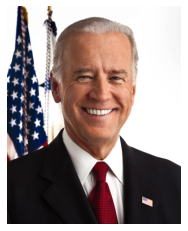

This is likely a Republican.
Probability of being a Republican:  [[0.95315737]]
Probability of being a Democrat:  [[0.04684263]]


In [46]:
test_single_image('biden.jpg', model) # Actually a Democrat

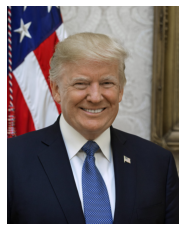

This is likely a Republican.
Probability of being a Republican:  [[0.97022176]]
Probability of being a Democrat:  [[0.02977824]]


In [47]:
test_single_image('trump.jpg', model)  # Actually a Republican

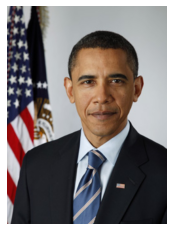

This is likely a Republican.
Probability of being a Republican:  [[0.92380476]]
Probability of being a Democrat:  [[0.07619524]]


In [48]:
test_single_image('obama.jpg', model) # Actually a Democrat

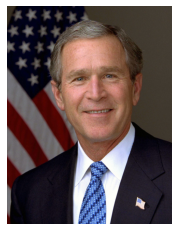

This is likely a Republican.
Probability of being a Republican:  [[0.5445132]]
Probability of being a Democrat:  [[0.45548677]]


In [49]:
test_single_image('w_bush.jpeg', model) # Actually a Republican

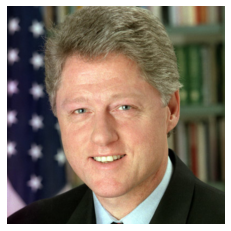

This is likely a Democrat.
Probability of being a Republican:  [[0.16038635]]
Probability of being a Democrat:  [[0.8396137]]


In [50]:
test_single_image('bill_clinton.jpg', model) # Actually a Democrat

#### Test other prominent politicials not included in the dataset

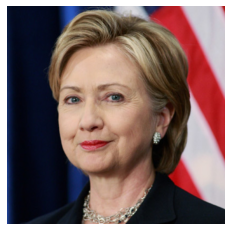

This is likely a Democrat.
Probability of being a Republican:  [[0.05721718]]
Probability of being a Democrat:  [[0.9427828]]


In [72]:
test_single_image('hillary.jpg', model) # Actually a Democrat

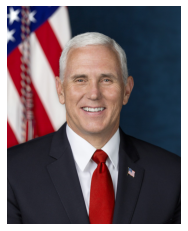

This is likely a Democrat.
Probability of being a Republican:  [[0.41173124]]
Probability of being a Democrat:  [[0.58826876]]


In [73]:
test_single_image('pence.jpg', model) # Actually a Republican

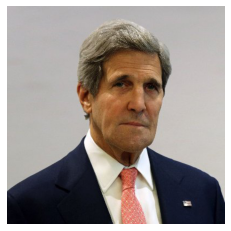

This is likely a Republican.
Probability of being a Republican:  [[0.99084616]]
Probability of being a Democrat:  [[0.00915384]]


In [56]:
test_single_image('kerry.jpg', model) # Actually a Democrat

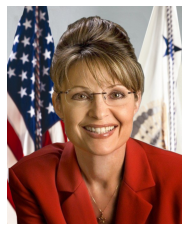

This is likely a Democrat.
Probability of being a Republican:  [[0.00334591]]
Probability of being a Democrat:  [[0.9966541]]


In [54]:
test_single_image('palin.jpg', model) # Actually a Republican

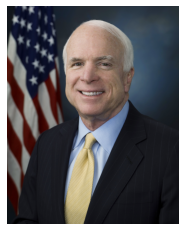

This is likely a Republican.
Probability of being a Republican:  [[0.9978947]]
Probability of being a Democrat:  [[0.0021053]]


In [57]:
test_single_image('mccain.jpg', model) # Actually a Republican

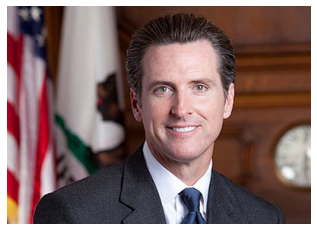

This is likely a Republican.
Probability of being a Republican:  [[0.9129263]]
Probability of being a Democrat:  [[0.08707368]]


In [55]:
test_single_image('newsom.jpg', model) # Actually a Democrat

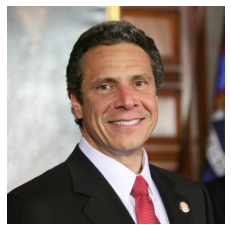

This is likely a Republican.
Probability of being a Republican:  [[0.51154685]]
Probability of being a Democrat:  [[0.48845315]]


In [58]:
test_single_image('cuomo.jpg', model) # Actually a Democrat

#### Test prominent politicians who were in the dataset. Note, some of the images are not the exact ones that appeared in the dataset.

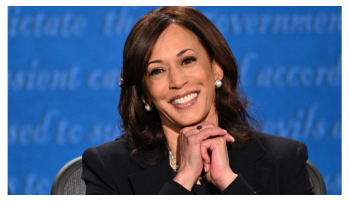

This is likely a Democrat.
Probability of being a Republican:  [[0.14310473]]
Probability of being a Democrat:  [[0.85689527]]


In [63]:
test_single_image('harris.jpg', model) # Actually a Democrat

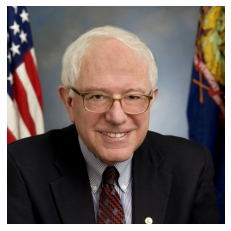

This is likely a Democrat.
Probability of being a Republican:  [[0.06088996]]
Probability of being a Democrat:  [[0.93911004]]


In [64]:
# Actually a Democrat (not really but he caucuses with them, so he's labeled a Democrat in my dataset)
test_single_image('sanders.jpg', model)

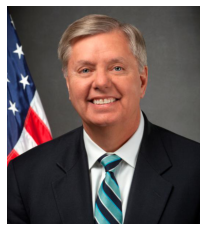

This is likely a Republican.
Probability of being a Republican:  [[0.84275913]]
Probability of being a Democrat:  [[0.15724087]]


In [66]:
test_single_image('graham.jpg', model) # Actually a Republican

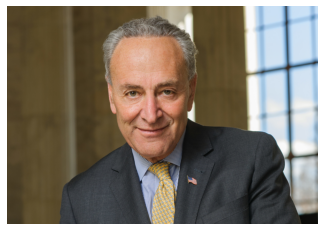

This is likely a Republican.
Probability of being a Republican:  [[0.97439694]]
Probability of being a Democrat:  [[0.02560306]]


In [68]:
test_single_image('schumer.jpg', model) # Actually a Democrat

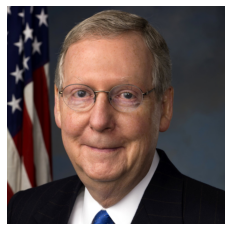

This is likely a Republican.
Probability of being a Republican:  [[0.973858]]
Probability of being a Democrat:  [[0.026142]]


In [74]:
test_single_image('mitch.jpg', model) # Actually a Republican

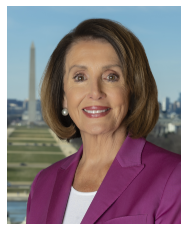

This is likely a Democrat.
Probability of being a Republican:  [[0.13692164]]
Probability of being a Democrat:  [[0.86307836]]


In [75]:
test_single_image('pelosi.jpg', model) # Actually a Democrat

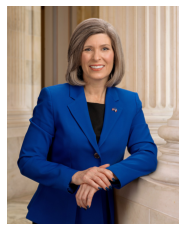

This is likely a Republican.
Probability of being a Republican:  [[0.85434645]]
Probability of being a Democrat:  [[0.14565355]]


In [79]:
test_single_image('ernst.jpg', model) # Actually a Republican

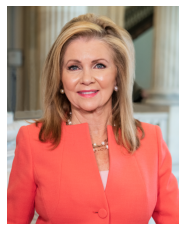

This is likely a Republican.
Probability of being a Republican:  [[0.551074]]
Probability of being a Democrat:  [[0.44892597]]


In [78]:
test_single_image('blackburn.jpg', model) # Actually a Republican

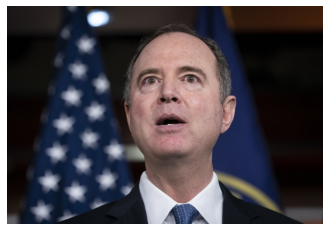

This is likely a Democrat.
Probability of being a Republican:  [[0.3780361]]
Probability of being a Democrat:  [[0.62196386]]


In [51]:
test_single_image('schiff.jpg', model) # Actually a Democrat

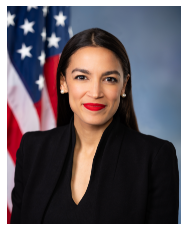

This is likely a Democrat.
Probability of being a Republican:  [[0.02555954]]
Probability of being a Democrat:  [[0.97444046]]


In [65]:
test_single_image('aoc.jpg', model) # Actually a Democrat

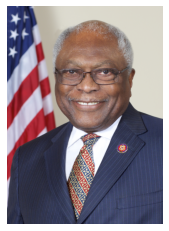

This is likely a Democrat.
Probability of being a Republican:  [[0.09605703]]
Probability of being a Democrat:  [[0.90394294]]


In [45]:
test_single_image('clyburn.jpg', model) # Actually a Democrat

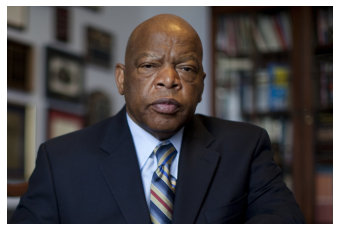

This is likely a Democrat.
Probability of being a Republican:  [[0.00785258]]
Probability of being a Democrat:  [[0.99214745]]


In [28]:
test_single_image('lewis.jpg', model) # Actually a Democrat

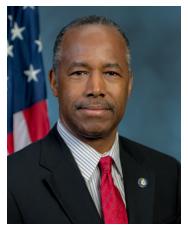

This is likely a Democrat.
Probability of being a Republican:  [[0.01269865]]
Probability of being a Democrat:  [[0.98730135]]


In [76]:
test_single_image('carson.jpg', model) # Actually a Republican

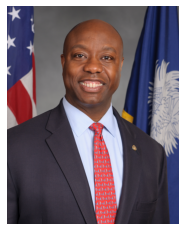

This is likely a Republican.
Probability of being a Republican:  [[0.98411596]]
Probability of being a Democrat:  [[0.01588404]]


In [77]:
test_single_image('scott.jpg', model) # Actually a Republican

## Conclusion and Final Thoughts

It's clear from the examples above that the model is not perfect. It says Obama and Biden are Republicans! It also predicts that Sarah Palin and Mike Pence are Democrats. This brings us face to face with the major disadvantage of deep learning models: they are black boxes. Because my model is a black box, I don’t know why it makes the decisions it does, which means that it's difficult for me to correct the model’s mistakes. At this point, my best bet for improving the model’s performance would be to get more labeled images for the model to train on.

Finally, I would be remiss not to mention the ethical implications of this project. I have essentially built a model that learns physical stereotypes about Democrats and Republicans. Ask yourself, why does the model incorrectly predict Ben Carson and Sarah Palin are Democrats but think Joe Biden and Gavin Newsom are Republicans? The inscrutable nature of neural nets makes this question impossible to answer, but the likely answer is that the overwhelming majority of Black members of Congress and the majority of women in Congress are Democrats. Therefore, the model was trained on data where most of the Black people and most of the women it saw were Democrats. Now it's not surprising that the model found these race and gender-based heuristics: if you are trying to determine a person's political preferences and the only information you have about that person is how they look, then you will by definition have to rely on gender, racial, and age stereotypes to make your guess. So we can't fault the CNN for finding and exploiting these heuristics. However, this does highlight how sensitive AI models are to biases in their training data and how careful we must be to mitigate biases when curating our training data. Nevertheless, sometimes the data are not unfairly biased but rather reflect actual trends that the model can reveal. In the case of predicting political preferences from images, I believe the model has not stereotyped different groups but instead has highlighted our current state of politics in which gender and race demarcate stark electoral dividing lines.

#### Bonus: Just for fun...

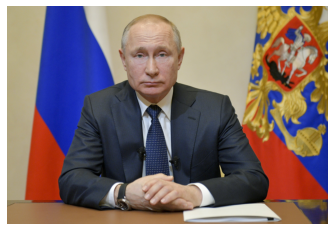

This is likely a Republican.
Probability of being a Republican:  [[0.9484773]]
Probability of being a Democrat:  [[0.05152267]]


In [67]:
test_single_image('putin.jpeg', model)